In [128]:
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import spacy
import re
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import re

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

## Functions for Cleaning Text

In [9]:
re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
def sub_br(x): return re_br.sub("\n", x)

my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(sub_br(x))]

## Functions for TFIDF

In [46]:
def clean_text(arr):
    cleaned_texts = []
    stop_words = set(stopwords.words('english')) 
    lemmatizer = WordNetLemmatizer()
    for row in arr:
        text = "".join((char for char in row if char not in string.punctuation))
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = word_tokenize(text)
        text = [lemmatizer.lemmatize(w.lower()) for w in text if not w in stop_words] 
        cleaned_texts.append(text)
        
    return np.array(cleaned_texts)

def clean_text_tfidf(arr):
    cleaned_texts = []
    stop_words = set(stopwords.words('english')) 
    lemmatizer = WordNetLemmatizer()
    for row in arr:
        text = "".join((char for char in row if char not in string.punctuation))
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = word_tokenize(text)
        text = [lemmatizer.lemmatize(w.lower()) for w in text if not w in stop_words]
        text = ' '.join(text)
        text = text.replace('# ','#')
        cleaned_texts.append(text)
        
    return np.array(cleaned_texts)

## Functions for Encoding Sentences

In [11]:
def get_vocab(content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for line in content:
        for word in line.split():
            vocab[word] += 1
    return vocab

def encode_sentence(x, vocab2index, N=26, padding_start=True):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = [vocab2index.get(w, vocab2index["UNK"]) for w in x.split()]
    l = min(N, len(enc1))
    if padding_start:
        enc[N-l:] = enc1[:l]
    else:
        enc = enc1[:l]
    return enc

In [127]:
class TweetDataset(Dataset):
    def __init__(self, X, y, N = 26, padding_start = True):
        X_text = X[:,0]
        X_num = np.array(X[:,1:], dtype=np.float)
        self.X_text = np.array([encode_sentence(x,vocab2index, N, padding_start) for x in X_text])
        scaler = StandardScaler()
        self.X_num = scaler.fit_transform(X_num)
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x_text = self.X_text[idx]
        x_num = self.X_num[idx]
        return x_text, x_num, self.y[idx]

## Gather Pre-Training Embeddings

In [13]:
def unpack_glove():
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
    ! mkdir data
    ! unzip glove.6B.zip
    
def delete_rare_words(word_vecs, word_count, min_df=4):
    words_delete = []
    for word in word_count:
        if word_count[word] < min_df and word not in word_vecs:
            words_delete.append(word)
    for word in words_delete: word_count.pop(word)
    return word_count

def loadGloveModel(gloveFile="glove.6B.50d.txt"):
    """ Loads word vecgors into a dictionary"""
    f = open(gloveFile,'r')
    word_vecs = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        word_vecs[word] = np.array([float(val) for val in splitLine[1:]])
    return word_vecs

def create_embedding_matrix(word_vecs, word_count, min_df=4, emb_size=50):
    """Creates embedding matrix from word vectors. """
    word_count = delete_rare_words(word_vecs, word_count, min_df)
    V = len(word_count.keys()) + 2
    vocab2index = {}
    W = np.zeros((V, emb_size), dtype="float32")
    vocab = ["", "UNK"]
    # adding a vector for padding
    W[0] = np.zeros(emb_size, dtype='float32')
    # adding a vector for rare words 
    W[1] = np.random.uniform(-0.25, 0.25, emb_size)
    vocab2index["UNK"] = 1
    i = 2
    for word in word_count:
        if word in word_vecs:
            W[i] = word_vecs[word]
            vocab2index[word] = i
            vocab.append(word)
            i += 1
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
            vocab2index[word] = i
            vocab.append(word)
            i += 1   
    return W, np.array(vocab), vocab2index

## CNN Model 

In [108]:
class Tweet_CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, num_cont, hidden_dim1 = 25, 
                 hidden_dim2 = 15, hidden_dim3 = 10, hidden_dim4 = 5,
                 glove_weights=None):
        super(Tweet_CNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, emb_size, padding_idx = 0)
        
        if glove_weights is not None:
            self.embed.weight.data.copy_(torch.from_numpy(glove_weights))
            self.embed.weight.requires_grad = False
            
        # For the Text Data
        self.conv1 = nn.Conv1d(emb_size, hidden_dim1, kernel_size=1)
        self.conv2 = nn.Conv1d(emb_size, hidden_dim1, kernel_size=2)
        self.conv3 = nn.Conv1d(emb_size, hidden_dim1, kernel_size=3)
        
        self.pool1 = nn.AvgPool1d(kernel_size = 26)
        self.pool2 = nn.AvgPool1d(kernel_size = 25)
        self.pool3 = nn.AvgPool1d(kernel_size = 24)
        self.dropout = nn.Dropout(p=0.5)
        
        # For the Numeric Data
        in_dim = num_cont
        self.linear1 = nn.Linear(in_dim, hidden_dim2)
        self.bn1 = nn.BatchNorm1d(hidden_dim2)
        self.linear2 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn2 = nn.BatchNorm1d(hidden_dim3)
        
        # For Both
        self.linear3 = nn.Linear(hidden_dim1*3 + hidden_dim3,hidden_dim4)
        self.bn = nn.BatchNorm1d(hidden_dim4)
        self.fc = nn.Linear(hidden_dim4, 1)

    def forward(self, x_text, x_num):
        
        # Text Data
        x_text = self.embed(x_text)
        x_text = x_text.transpose(1,2)
        x1 = self.pool1(F.relu(self.conv1(x_text)))
        x2 = self.pool2(F.relu(self.conv2(x_text)))
        x3 = self.pool3(F.relu(self.conv3(x_text)))
        
        # numeric data
        x4 = self.bn1(F.relu(self.linear1(x_num)))
        x4 = self.dropout(x4)
        x4 = self.bn2(F.relu(self.linear2(x4)))
        
        # Combine it all together
        out = torch.cat([x1, x2, x3], 2)
        out = out.view(out.size(0), -1)
        out = torch.cat([out, x4],1)
        out = self.dropout(self.bn(F.relu(self.linear3(out))))
        
        return self.fc(out)

## Training Functions

In [15]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [166]:
def train_epocs(model, optimizer, epochs=10, max_lr=0.01):
    max_f1 = 0
    max_acc = 0
    min_loss = 1000000
    for i in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        iterations = epochs*len(train_dl)
        idx = 0
        lrs = get_cosine_triangular_lr(max_lr, iterations)
        for x_text, x_num, y in train_dl:
            lr = lrs[idx]
            update_optimizer(optimizer,lr)
            x_text = x_text.long()
            x_num = x_num.float()
            y = y.float().unsqueeze(1)
            out = model(x_text, x_num)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += x_num.size(0)*loss.item()
            total += x_num.size(0)
            idx +=1
        train_loss = total_loss/total
        val_loss, val_accuracy, val_f1 = valid_metrics(model)
        
        if val_f1 > max_f1:
            max_f1 = val_f1
            max_acc = val_accuracy
            min_loss = val_loss
            path = "models/model_f1_{0:.3f}.pth".format(val_f1) 
            save_model(model, path)  
            print("Best Scores: val_loss %.3f val_accuracy %.3f val_f1 %.3f" % (min_loss, max_acc, max_f1))
        if i % 20 == 0:
            print("train_loss %.3f val_loss %.3f val_accuracy %.3f val_f1 %.3f" % (
                    train_loss, val_loss, val_accuracy, val_f1))

In [167]:
def valid_metrics(model):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    y_all = []
    y_pred_all = []
    for x_text, x_num, y in valid_dl:
        x_text = x_text.long()
        x_num = x_num.float()
        y = y.float().unsqueeze(1)
        batch = y.shape[0]
        out = model(x_text, x_num)
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = (out > 0).float()
        y_pred_all.extend(pred)
        y_all.extend(y)
        correct += (pred == y).float().sum().item()
    val_loss = sum_loss/total
    val_acc = correct/total
    val_f1 = f1_score(y_pred_all, y_all)
    return val_loss, val_acc, val_f1

## Learning Rate Finding

In [168]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

def update_optimizer(optimizer, lr):
    for _,param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [169]:
def LR_range_finder(model, optimizer, train_dl, lr_low=1e-5, lr_high=1e-2, epochs=2):
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x_text, x_num, y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer,lr)
            x_text = x_text.long() #.cuda()
            x_num = x_num.float()
            y = y.float().unsqueeze(1) #.cuda()
            out = model(x_text, x_num)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
    return lrs, losses 

## Model Troubleshooting

In [897]:
x_text, x_num ,y = next(iter(train_dl))

In [898]:
x_num.shape

torch.Size([256, 4])

In [899]:
x_text.shape

torch.Size([256, 26])

In [900]:
V = len(words)
emb_size = 3

In [901]:
embed = nn.Embedding(V, emb_size, padding_idx=0)

In [902]:
# Kernal = 1

In [903]:
x1 = embed(x.long())

In [904]:
x1.transpose(1,2).shape

torch.Size([2, 3, 26])

In [905]:
x1 = embed(x_text.long())
x1 = x1.transpose(1,2)
x1.size()
conv_1 = nn.Conv1d(in_channels=emb_size, out_channels=100, kernel_size=1)
x1 = F.relu(conv_1(x1))
pool1 = nn.MaxPool1d(kernel_size = 26)
x1 = pool1(x1)

In [906]:
conv_1(embed(x.long()).transpose(1,2)).shape

torch.Size([2, 100, 26])

In [907]:
x1.shape

torch.Size([256, 100, 1])

In [908]:
## Kernal = 2

In [909]:
x2 = embed(x_text.long())
x2 = x2.transpose(1,2)
x2.size()
conv_2 = nn.Conv1d(in_channels=emb_size, out_channels=100, kernel_size=2)
x2 = F.relu(conv_2(x2))
pool2 = nn.MaxPool1d(kernel_size = 25)
x2 = pool2(x2)

In [910]:
## Kernal = 3

In [911]:
x3 = embed(x_text.long())
x3 = x3.transpose(1,2)
x3.size()
conv_3 = nn.Conv1d(in_channels=emb_size, out_channels=100, kernel_size=3)
x3 = F.relu(conv_3(x3))
pool3 = nn.MaxPool1d(kernel_size = 24)
x3 = pool3(x3)

In [912]:
## Numeric Data

In [953]:
valid_metrics(model)

(0.8310468466126911, 0.5502298095863427, 0.4258172673931266)

In [914]:
x_num = x_num.float()

In [915]:
in_dim = 4
linear1 = nn.Linear(in_dim, 50)
bn1 = nn.BatchNorm1d(50)
linear2 = nn.Linear(50, 50)
bn2 = nn.BatchNorm1d(50)

In [916]:
x4 = bn1(F.relu(linear1(x_num)))
x4 = dropout(x4)
x4 = bn2(F.relu(linear2(x4)))

In [917]:
x4.shape

torch.Size([256, 50])

In [918]:
x1.shape

torch.Size([256, 100, 1])

In [919]:
out = torch.cat([x1, x2, x3], 2)

In [920]:
out = out.view(out.size(0), -1)

In [921]:
out.shape

torch.Size([256, 300])

In [922]:
dropout = nn.Dropout(p=0.2)
out = dropout(bn(out))

In [923]:
x4.shape

torch.Size([256, 50])

In [924]:
out = torch.cat([out, x4],1)

In [926]:
out.shape

torch.Size([256, 350])

In [930]:
bn = nn.BatchNorm1d(350)
out = dropout(bn(out))

In [932]:
fc = nn.Linear(350, 1)
fc(out).shape

torch.Size([256, 1])

## Running everything

In [379]:
#unpack_glove()

--2020-06-21 18:57:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-21 18:57:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-21 18:57:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [170]:
disaster = pd.read_csv('nlp-getting-started/train.csv')

In [171]:
X = disaster.text
y = np.array(disaster.target)

In [172]:
text_data = np.array(X)

In [173]:
cleaned_text = clean_text_tfidf(text_data)

In [174]:
cleaned_text

array(['our deed reason earthquake may allah forgive u',
       'forest fire near la ronge sask canada',
       'all resident asked shelter place notified officer no evacuation shelter place order expected',
       ..., 'm194 0104 utc5km s volcano hawaii httptcozdtoyd8ebj',
       'police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injury',
       'the latest more home razed northern california wildfire abc news httptcoymy4rskq3d'],
      dtype='<U138')

In [175]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range = (2,3))
features = tfidf.fit_transform(cleaned_text)
X = np.array(pd.concat([pd.DataFrame(X),pd.DataFrame(features.todense())],axis=1))

In [176]:
in_dim = X.shape[1]-1

In [177]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=40)

In [178]:
X_train_text = X_train[:,0]

In [179]:
word_count = get_vocab(X_train_text)
for word in list(word_count):
    if word_count[word] < 5:
        del word_count[word]

In [180]:
vocab2index = {"<PAD>":0, "UNK":1} # init with padding and unknown
words = ["<PAD>", "UNK"]
for word in word_count:
    vocab2index[word] = len(words)
    words.append(word)

In [146]:
word_vecs = loadGloveModel(gloveFile="glove.6B.50d.txt")
word_count = delete_rare_words(word_vecs, word_count)
pretrained_weight, vocab, vocab2index = create_embedding_matrix(word_vecs, word_count, emb_size=50)

In [181]:
V = len(words)
emb_size = 50

In [182]:
train_ds = TweetDataset(X_train, y_train)
valid_ds = TweetDataset(X_val, y_val)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

In [183]:
model = Tweet_CNN(V, emb_size,in_dim,glove_weights=pretrained_weight)

In [184]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
lrs,losses = LR_range_finder(model, optimizer, train_dl)

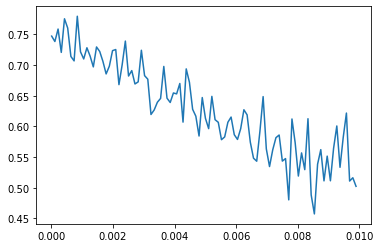

In [185]:
plt.plot(lrs, losses)
plt.show()

In [187]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_epocs(model, optimizer, epochs = 1000, max_lr = 1e-4)

Best Scores: val_loss 0.515 val_accuracy 0.758 val_f1 0.673
train_loss 0.532 val_loss 0.515 val_accuracy 0.758 val_f1 0.673
Best Scores: val_loss 0.515 val_accuracy 0.758 val_f1 0.673
Best Scores: val_loss 0.515 val_accuracy 0.758 val_f1 0.676
Best Scores: val_loss 0.514 val_accuracy 0.760 val_f1 0.680
train_loss 0.541 val_loss 0.514 val_accuracy 0.759 val_f1 0.677
train_loss 0.537 val_loss 0.513 val_accuracy 0.759 val_f1 0.676
train_loss 0.533 val_loss 0.514 val_accuracy 0.759 val_f1 0.672
train_loss 0.539 val_loss 0.513 val_accuracy 0.759 val_f1 0.676
train_loss 0.535 val_loss 0.511 val_accuracy 0.760 val_f1 0.678
train_loss 0.528 val_loss 0.512 val_accuracy 0.760 val_f1 0.677
train_loss 0.532 val_loss 0.512 val_accuracy 0.760 val_f1 0.674
train_loss 0.537 val_loss 0.513 val_accuracy 0.761 val_f1 0.676
train_loss 0.530 val_loss 0.513 val_accuracy 0.758 val_f1 0.673
train_loss 0.538 val_loss 0.512 val_accuracy 0.760 val_f1 0.674
Best Scores: val_loss 0.508 val_accuracy 0.759 val_f1 0.